In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GRU, SimpleRNN, Conv1D, GlobalMaxPooling1D, MultiHeadAttention, Dropout, Flatten, Bidirectional
from tensorflow.keras.regularizers import l2
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import KFold

%load_ext autoreload
%autoreload 2

/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data load and preprocessing

### Load data - full and summarised versions

In [3]:
# Load data
df_train = pd.read_csv("../data/balanced/train.csv")
df_test = pd.read_csv("../data/balanced/test.csv")

# Prepare train and test data and labels
train_texts = df_train['content']
test_texts = df_test['content']
train_labels = np.asarray(df_train['flag']).astype('float32')
test_labels = np.asarray(df_test['flag']).astype('float32')

In [ ]:
# Load GPT-2 summarised data

df_train_gpt2 = pd.read_csv("../data/summarised/train_summarised_gpt2.csv")
df_test_gpt2 = pd.read_csv("../data/summarised/test_summarised_gpt2.csv")

# Prepare train and test data and labels
train_texts_gpt2 = df_train_gpt2['summarised']
test_texts_gpt2 = df_test_gpt2['summarised']

In [59]:
# Load Pagerank-summarised data

df_train_pagerank_1 = pd.read_csv("../data/train_with_pagerank_part1.csv")
df_train_pagerank_2 = pd.read_csv("../data/train_with_pagerank_part2.csv")
df_test_pagerank = pd.read_csv("../data/test_with_pagerank.csv")

# Combine the two parts of the training data
df_train_pagerank = pd.concat([df_train_pagerank_1, df_train_pagerank_2])

# Prepare train and test data and labels
train_texts_pagerank = df_train_pagerank['pagerank']
test_texts_pagerank = df_test_pagerank['pagerank']

### Preprocess using Keras tokeniser

#### Get optimal parameters

In [28]:
def get_optimal_params(texts):

    # Initialize the tokenizer with a very high num_words to include all words
    tokenizer = Tokenizer(num_words=100000)
    tokenizer.fit_on_texts(texts)
    word_index = tokenizer.word_index
    sequences = tokenizer.texts_to_sequences(texts)
    sequence_lengths = [len(seq) for seq in sequences]
    
    # Calculate and print statistics about sequence lengths
    mean_length = np.mean(sequence_lengths)
    max_length = np.max(sequence_lengths)
    max_len = int(np.percentile(sequence_lengths, 95))
    vocab_size = len(word_index) + 1  # Including 0 index for padding
    
    print(f'Found {len(word_index)} unique tokens.')
    print(f"Mean sequence length: {mean_length}")
    print(f"Maximum sequence length: {max_length}")
    print(f"Chosen max_len based on 95th percentile: {max_len}")

    # Plot the distribution of sequence lengths
    plt.figure(figsize=(4, 3))
    sns.histplot(sequence_lengths, bins=50, kde=True)
    plt.title("Distribution of Sequence Lengths")
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.axvline(x=max_len, color='red', linestyle='--', label=f'95th Percentile: {max_len}')
    plt.legend()
    plt.show()
    
    return max_len, vocab_size

Found 41671 unique tokens.
Mean sequence length: 381.96330022075057
Maximum sequence length: 1981
Chosen max_len based on 95th percentile: 668


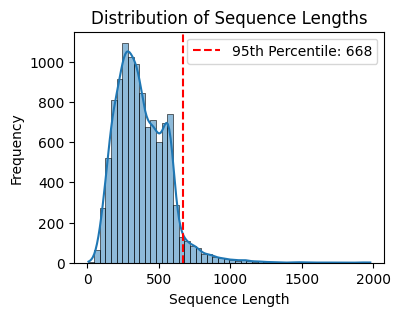

In [29]:
# Get optimal parameters
max_len, vocab_size = get_optimal_params(train_texts)

Found 20251 unique tokens.
Mean sequence length: 73.8021523178808
Maximum sequence length: 343
Chosen max_len based on 95th percentile: 131


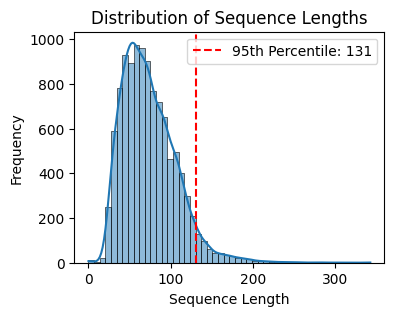

In [39]:
# Get optimal parameters for summarised texts
max_len_gpt2, vocab_size_gpt2 = get_optimal_params(train_texts_gpt2)

Found 24718 unique tokens.
Mean sequence length: 126.92135761589404
Maximum sequence length: 594
Chosen max_len based on 95th percentile: 208


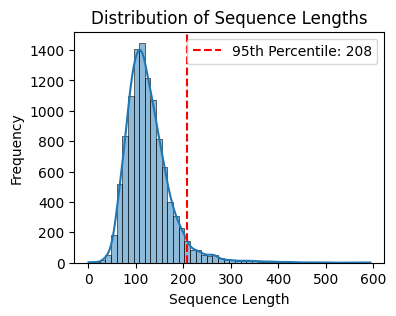

In [60]:
# Get optimal parameters for pagerank texts
max_len_pagerank, vocab_size_pagerank = get_optimal_params(train_texts_pagerank)

#### Get tokenised sequences for train and test data

In [40]:
# Preprocessing for RNN using Keras tokeniser
def preprocess_sequences(train_texts, test_texts, num_words, maxlen=650):

    # Initialize and fit the tokenizer
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(train_texts)
    
    # Prepare training data
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    train_sequences = pad_sequences(train_sequences, maxlen=maxlen)

    # Prepare testing data
    test_sequences = tokenizer.texts_to_sequences(test_texts)
    test_sequences = pad_sequences(test_sequences, maxlen=maxlen)
    
    return train_sequences, test_sequences

In [43]:
# Preprocess sequences
train_sequences, test_sequences = preprocess_sequences(train_texts, test_texts, num_words=vocab_size, maxlen=650)

In [47]:
# Preprocess GPT-2 summarised sequences
train_sequences_gpt2, test_sequences_gpt2 = preprocess_sequences(train_texts_gpt2, test_texts_gpt2, num_words=vocab_size_gpt2, maxlen=130)

In [62]:
# Preprocess Pagerank summarised sequences
train_sequences_pagerank, test_sequences_pagerank = preprocess_sequences(train_texts_pagerank, test_texts_pagerank, num_words=vocab_size_pagerank, maxlen=200)

### BERT Embeddings

Maximum sequence length: 423
Average sequence length: 91.93377483443709
Chosen max_len: 162.0


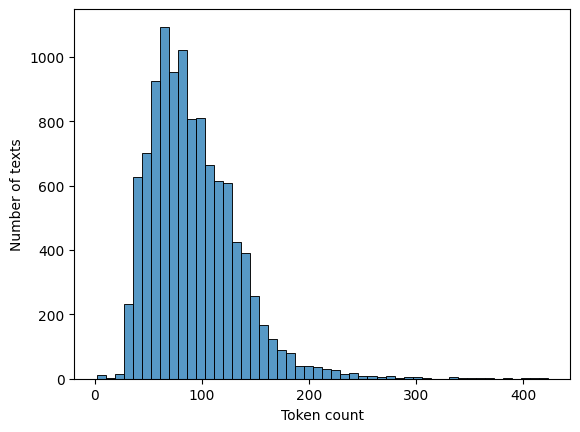

In [65]:
# Find optimal maximum sequence length for BERT

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Preliminary tokenization to find optimal max_len
token_lens = []
for txt in train_texts_gpt2: 
    tokens = tokenizer.encode(txt)
    token_lens.append(len(tokens))

# Analyze the distribution and choose max len based on a value that covers 95% of the texts
print(f"Maximum sequence length: {max(token_lens)}")
print(f"Average sequence length: {np.mean(token_lens)}")
max_len_bert = np.quantile(token_lens, 0.95)
print(f"Chosen max_len: {max_len_bert}")

# Plot the distribution
sns.histplot(token_lens, bins=50)
plt.xlabel('Token count')
plt.ylabel('Number of texts')
plt.show()

In [66]:
# Generate BERT embeddings
def preprocess_bert_embeddings(data, max_len):
    # Initialize the tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    # Tokenize the text and convert to required format for BERT
    encoded_batch = tokenizer.batch_encode_plus(
        data.tolist(),
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoded_batch['input_ids']
    attention_mask = encoded_batch['attention_mask']

    model.eval()

    # Obtain embeddings
    with torch.no_grad():  # Disable gradient calculations for inference
        outputs = model(input_ids, attention_mask=attention_mask)
    embeddings = outputs.last_hidden_state
    
    # Convert embeddings to numpy array
    embeddings = embeddings.cpu().numpy() 

    return embeddings

In [67]:
# Preprocess BERT embeddings
train_embeddings = preprocess_bert_embeddings(train_texts_gpt2, max_len=160)
test_embeddings = preprocess_bert_embeddings(test_texts_gpt2, max_len=160)

: 

## Define Models

In [48]:
class BaseModel(Model):
    def __init__(self):
        super(BaseModel, self).__init__()
    
    def compile(self, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
        super(BaseModel, self).compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [49]:
class RNNModel(BaseModel):
    def __init__(self, input_shape, vocab_size, embedding_dim):
        super(RNNModel, self).__init__()
        self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=input_shape)
        self.biLSTM = Bidirectional(LSTM(32, return_sequences=False))
        self.dense = Dense(64, activation="relu")
        self.dropout = Dropout(0.1)
        self.output_layer = Dense(1, activation='sigmoid')
    
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.biLSTM(x)
        x = self.dense(x)
        x = self.dropout(x)
        return self.output_layer(x)


In [50]:
class RNNAttentionModel(BaseModel):
    def __init__(self, input_shape, vocab_size, embedding_dim):
        super(RNNAttentionModel, self).__init__()
        self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(input_shape))
        self.attention = MultiHeadAttention(num_heads=4, key_dim=32)
        self.biLSTM = Bidirectional(LSTM(32, return_sequences=False))
        self.dense = Dense(32, activation="relu")
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.attention(x, x)
        x = self.biLSTM(x)
        x = self.dense(x)
        return self.output_layer(x)

In [51]:
class CNNModel(BaseModel):
    def __init__(self, input_shape, vocab_size, embedding_dim):
        super(CNNModel, self).__init__()
        self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=input_shape)
        self.conv1 = Conv1D(filters=64, kernel_size=10, activation='relu')
        self.pool = GlobalMaxPooling1D()
        self.conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')
        self.pool2 = GlobalMaxPooling1D()
        self.conv3 = Conv1D(filters=64, kernel_size=3, activation='relu')
        self.pool3 = GlobalMaxPooling1D()
        self.concat = tf.keras.layers.Concatenate()
        self.dense = Dense(32, activation='relu')
        self.output_layer = Dense(1, activation='sigmoid')
    
    def call(self, inputs):
        x = self.embedding(inputs)
        conv1 = self.conv1(x)
        conv1 = self.pool(x)
        conv2 = self.conv2(x)
        conv2 = self.pool2(x)
        conv3 = self.conv3(x)
        conv3 = self.pool3(x)
        x = self.concat([conv1, conv2 , conv3])
        x = self.dense(x)
        return self.output_layer(x)

In [52]:
class CNNAttentionModel(Model):
    def __init__(self, input_shape, vocab_size, embedding_dim):
        super(CNNAttentionModel, self).__init__()
        self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=input_shape)
        self.attention = MultiHeadAttention(num_heads=4, key_dim=32)
        self.conv1 = Conv1D(filters=32, kernel_size=10, activation='relu')
        self.pool1 = GlobalMaxPooling1D()
        self.conv2 = Conv1D(filters=32, kernel_size=5, activation='relu')
        self.pool2 = GlobalMaxPooling1D()
        self.conv3 = Conv1D(filters=32, kernel_size=3, activation='relu')
        self.pool3 = GlobalMaxPooling1D()
        self.concat = tf.keras.layers.Concatenate()
        self.dense = Dense(64, activation='relu')
        self.output_layer = Dense(1, activation='sigmoid')
    
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.attention(query=x, key=x, value=x)
        conv1 = self.conv1(x)
        conv1 = self.pool1(conv1)
        conv2 = self.conv2(x)
        conv2 = self.pool2(conv2)
        conv3 = self.conv3(x)
        conv3 = self.pool3(conv3)
        x = self.concat([conv1, conv2 , conv3])
        x = self.dense(x)
        return self.output_layer(x)

In [53]:
def create_model(model_name, input_shape, vocab_size, embedding_dim):

    if model_name == 'RNN':
        model = RNNModel(input_shape=input_shape, vocab_size=vocab_size, embedding_dim=embedding_dim)
    elif model_name == 'RNN_Attention':
        model = RNNAttentionModel(input_shape=input_shape, vocab_size=vocab_size, embedding_dim=embedding_dim)
    elif model_name == 'CNN':
        model = CNNModel(input_shape=input_shape, vocab_size=vocab_size, embedding_dim=embedding_dim)
    elif model_name == 'CNN_Attention':
        model = CNNAttentionModel(input_shape=input_shape, vocab_size=vocab_size, embedding_dim=embedding_dim)

    model.compile()
    return model


In [57]:
# Model utilities
def evaluate(y_true, y_pred_probs, threshold=0.5):
    y_pred_binary = (y_pred_probs >= threshold).astype(int)
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred_binary),
        'precision': precision_score(y_true, y_pred_binary),
        'recall': recall_score(y_true, y_pred_binary),
        'f1_score': f1_score(y_true, y_pred_binary),
        'roc_auc': roc_auc_score(y_true, y_pred_probs),
        'confusion_matrix': confusion_matrix(y_true, y_pred_binary)
    }
    
    return metrics

def print_metrics(metrics):
    print("\n=== Evaluation Metrics ===")
    for metric, value in metrics.items():
        if metric != 'confusion_matrix': 
            print(f"{metric.capitalize()}: {value:.4f}")

def plot_graphs(y_true, y_pred_probs, metrics):
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics["roc_auc"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

def k_fold_cross_validation(model_name, X, y, input_shape, vocab_size, embedding_size, num_folds=3, num_epochs=10, batch_size=128):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    # Initialize dictionaries to store scores for each metric across all folds
    aggregated_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'roc_auc': []
    }
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"\nTraining on fold {fold+1}/{num_folds}...")
        
        # Split data
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        tf.keras.backend.clear_session()  
        model = create_model(model_name, input_shape, vocab_size, embedding_size)
        
        # Train the model
        model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size,
                  validation_data=(X_val_fold, y_val_fold), verbose=1)
        
        # Generate predictions and evaluate
        y_pred_probs = model.predict(X_val_fold).ravel()
        fold_metrics = evaluate(y_val_fold, y_pred_probs)
        
        # Append the fold's metrics to the aggregated_scores
        for metric in aggregated_scores.keys():
            aggregated_scores[metric].append(fold_metrics[metric])
    
    # After all folds are processed, print aggregated scores
    print(f"Model name: {model_name}")
    print_aggregated_scores(aggregated_scores)

def print_aggregated_scores(aggregated_scores):
    print("\n=== Aggregate Scores Across All Folds ===")
    for metric, scores in aggregated_scores.items():
        average_score = np.mean(scores)
        print(f"{metric.capitalize()}: {average_score:.4f} (± {np.std(scores):.4f})")

def train_and_test(model_name, X_train, y_train, X_test, y_test, input_shape, vocab_size, embedding_dim, num_epochs=5, batch_size=128):
    # Clearing the TensorFlow session 
    tf.keras.backend.clear_session()

    # Creating the model using the provided model creation function
    model = create_model(model_name, input_shape, vocab_size, embedding_dim)

    # Compiling and training the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1)

    # Generate predictions
    y_pred_probs = model.predict(X_test).ravel()

    # Evaluate to get metrics
    metrics = evaluate(y_test, y_pred_probs)

    # Print the metrics
    print_metrics(metrics)

    # Plot the graphs
    plot_graphs(y_test, y_pred_probs, metrics)

## Train Models using K-Fold Cross Validation

In [ ]:
# Train and evaluate RNN
k_fold_cross_validation('RNN', train_sequences, train_labels)

In [ ]:
# Train and evaluate RNN with Attention
k_fold_cross_validation('RNN_Attention', train_sequences, train_labels)

In [ ]:
# Train and evaluate CNN 
k_fold_cross_validation('CNN', train_sequences, train_labels)

In [ ]:
# Train and evaluate CNN with Attention
k_fold_cross_validation('CNN_Attention', train_sequences, train_labels)

## Test Models

Epoch 1/5


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - accuracy: 0.5277 - loss: 0.6904
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 464ms/step - accuracy: 0.6757 - loss: 0.6119
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 445ms/step - accuracy: 0.7755 - loss: 0.4931
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 472ms/step - accuracy: 0.8380 - loss: 0.4000
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 500ms/step - accuracy: 0.8904 - loss: 0.2800
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step

=== Evaluation Metrics ===
Accuracy: 0.5330
Precision: 0.2301
Recall: 0.7680
F1_score: 0.3541
Roc_auc: 0.6775


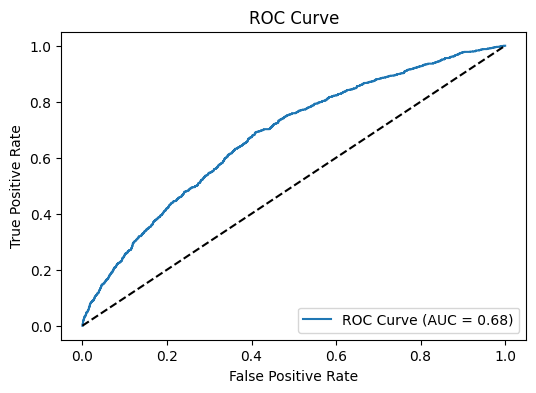

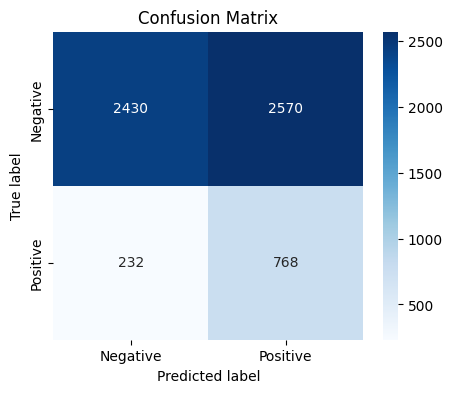

In [101]:
# Test RNN
train_and_test('RNN', train_sequences, train_labels, test_sequences, test_labels)

Epoch 1/5


85/85 ━━━━━━━━━━━━━━━━━━━━ 472s 6s/step - accuracy: 0.6044 - loss: 0.6654
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 724s 9s/step - accuracy: 0.6379 - loss: 0.6436
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 882s 10s/step - accuracy: 0.6659 - loss: 0.6216
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 726s 8s/step - accuracy: 0.7046 - loss: 0.5806
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 576s 7s/step - accuracy: 0.7631 - loss: 0.5063
188/188 ━━━━━━━━━━━━━━━━━━━━ 98s 520ms/step

=== Evaluation Metrics ===
Accuracy: 0.7793
Precision: 0.3949
Recall: 0.6090
F1_score: 0.4792
Roc_auc: 0.7918


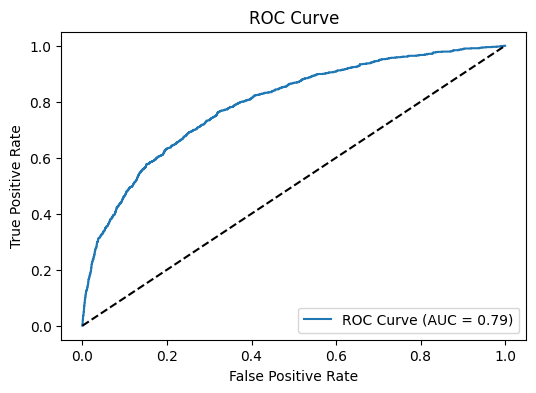

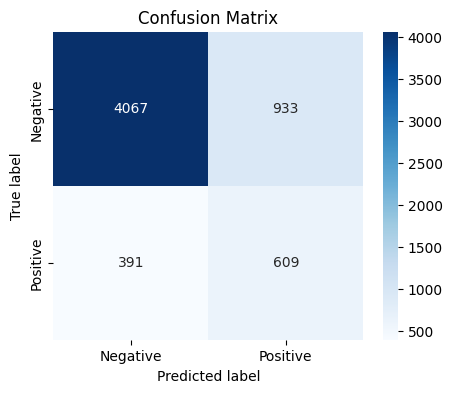

In [107]:
# Test RNN with Attention
train_and_test('RNN_Attention', train_sequences, train_labels, test_sequences, test_labels)

Epoch 1/5


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.5426 - loss: 0.6889
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.6749 - loss: 0.6214
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.7483 - loss: 0.5208
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.8263 - loss: 0.4129
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9047 - loss: 0.2823
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== Evaluation Metrics ===
Accuracy: 0.7177
Precision: 0.3343
Recall: 0.7000
F1_score: 0.4525
Roc_auc: 0.7777


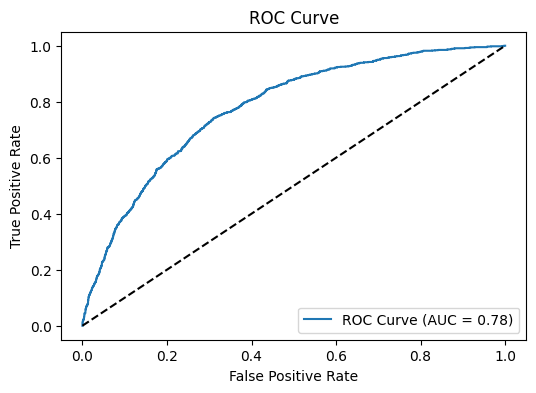

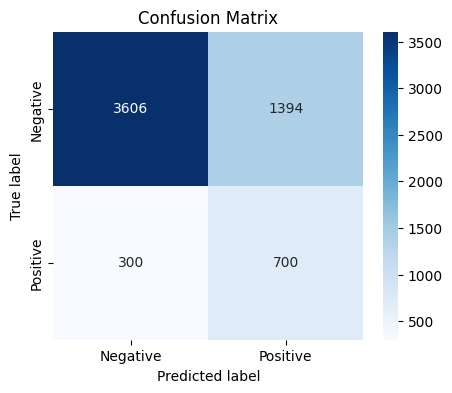

In [119]:
# Test CNN
train_and_test('CNN', train_sequences, train_labels, test_sequences, test_labels)

Epoch 1/5


85/85 ━━━━━━━━━━━━━━━━━━━━ 338s 4s/step - accuracy: 0.5631 - loss: 0.6750
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.6601 - loss: 0.6234
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 319s 4s/step - accuracy: 0.7343 - loss: 0.5123
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 325s 4s/step - accuracy: 0.7657 - loss: 0.4721
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step - accuracy: 0.8143 - loss: 0.4013
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 370ms/step

=== Evaluation Metrics ===
Accuracy: 0.8370
Precision: 0.5061
Recall: 0.9170
F1_score: 0.6522
Roc_auc: 0.9418


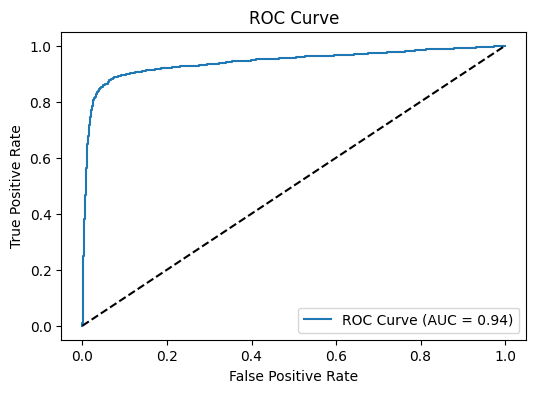

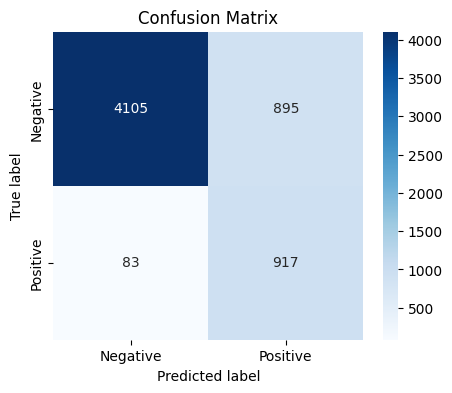

In [124]:
# Test CNN with Attention
train_and_test('CNN_Attention', train_sequences, train_labels, test_sequences, test_labels)

Epoch 1/5


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5984 - loss: 0.6632
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.6591 - loss: 0.6204
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7458 - loss: 0.5014
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.7816 - loss: 0.4475
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.8134 - loss: 0.3998
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step

=== Evaluation Metrics ===
Accuracy: 0.7722
Precision: 0.4169
Recall: 0.9210
F1_score: 0.5740
Roc_auc: 0.9247


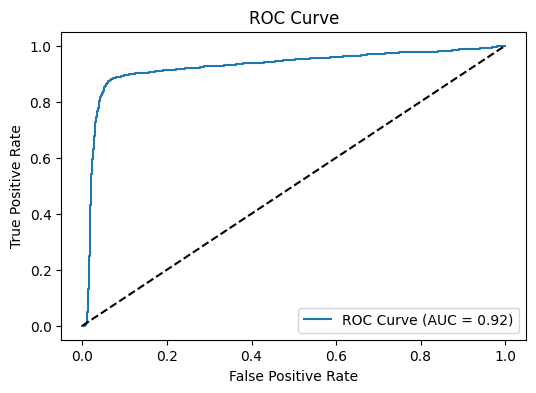

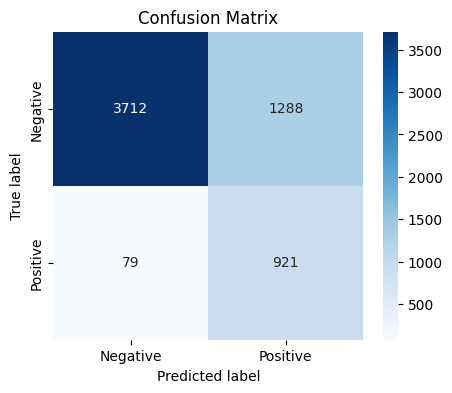

In [58]:
# Test CNN with Attention
train_and_test('CNN_Attention', train_sequences, train_labels, test_sequences, test_labels, input_shape=(130,), vocab_size=vocab_size_gpt2, embedding_dim=128)

Epoch 1/5


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.5462 - loss: 0.6831
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - accuracy: 0.6867 - loss: 0.5720
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - accuracy: 0.7511 - loss: 0.4973
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.7803 - loss: 0.4532
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.8315 - loss: 0.3710
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step

=== Evaluation Metrics ===
Accuracy: 0.5977
Precision: 0.2642
Recall: 0.7920
F1_score: 0.3962
Roc_auc: 0.7687


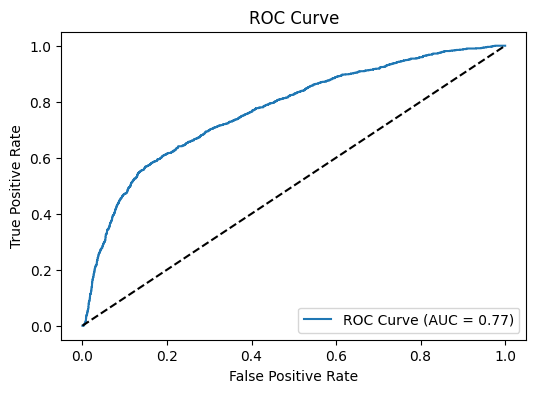

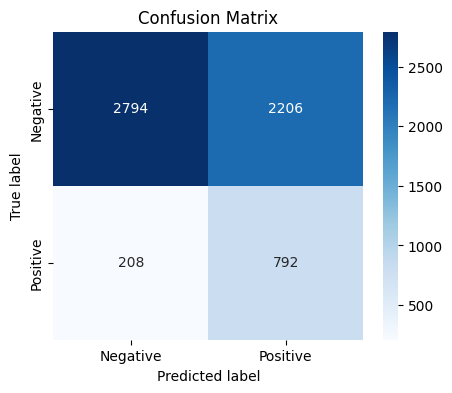

In [63]:
# Test CNN with Attention on Pagerank summarised data

train_and_test('CNN_Attention', train_sequences_pagerank, train_labels, test_sequences_pagerank, test_labels, input_shape=(200,), vocab_size=vocab_size_pagerank, embedding_dim=128)